In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
names = open("../names.txt", "r").read().splitlines()
names[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
# count the number of letters and prepare the index
letters = set()
for name in names:
    for c in name:
        letters.add(c)

letter_list = list(letters)
letter_list.append(".")
letter_list.sort()

stoi = {s:i for i, s in enumerate(letter_list)}
itos = {i:s for s, i in stoi.items()}

In [4]:
def prep_data(names, block_size):
    x, y = [], []
    for name in names:
    # add the necessary padding to the name
        modified_string = block_size * "." + name + "."
        for ch1, ch2, ch3, ch4 in zip(modified_string, modified_string[1:], modified_string[2:], modified_string[3:]):
            x.append([stoi[ch1], stoi[ch2], stoi[ch3]])
            y.append(stoi[ch4])

    X = torch.tensor(x)
    Y = torch.tensor(y)

    return X, Y

# The data will be split as such - 80% training, 10% dev, 10% test
BLOCK_SIZE = 3

import random
random.seed(42)
random.shuffle(names)

sample_size = len(names)
train_size = int(0.8 * sample_size)
dev_size = int(0.9 * sample_size)

print(train_size, dev_size)

Xtr, Ytr = prep_data(names[:train_size], BLOCK_SIZE)
Xdev, Ydev = prep_data(names[train_size:dev_size], BLOCK_SIZE)
Xtest, Ytest = prep_data(names[dev_size:], BLOCK_SIZE)

print(Xtr.shape, Xdev.shape, Xtest.shape)

25626 28829
torch.Size([182625, 3]) torch.Size([22655, 3]) torch.Size([22866, 3])


In [64]:
# torchify the code

class Linear:
    def __init__(self, fan_in, fan_out, gain=1, bias=True):
        self.weight = torch.randn((fan_in, fan_out)) / (fan_in**0.5)
        # seems like the biases should be torch.zeros?
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, input):
        self.out = input @ self.weight
        if self.bias != None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([self.bias] if self.bias != None else [])

    def shape(self):
        return self.weight.shape, self.bias.shape if self.bias != None else None

class Tanh:    
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []

class BatchNorm1d:
    def __init__(self, input_size, epsilon=1e-5, momentum=0.1):
        self.epsilon = epsilon
        self.momentum = momentum
        # initialise the running mean and running var
        self.training = True
       
        self.gamma = torch.ones(input_size)
        self.beta = torch.zeros(input_size)

        # for a normal distribution, the mean is 0 and the variance is 1
        self.running_mean = torch.zeros(input_size)
        self.running_var = torch.ones(input_size)

    # normalize the values
    def __call__(self, batch):
        # # when dim=0, the output will be (100, 100) -> (100) -> this means that there is one average for each column=
        # you only have to calculate the batch mean if you wanna update it
        if self.training:
            mean = batch.mean(0)
            var = batch.var(0)

        else:
            mean = self.running_mean
            var = self.running_var
            
        normalized = (batch - mean)/torch.sqrt(var + self.epsilon)
        self.out = normalized * self.gamma + self.beta
        
        # update the running values if training
        if self.training:
            with torch.no_grad():
                self.running_mean = self.running_mean * (1 - self.momentum) + mean * self.momentum
                self.running_var = self.running_var * (1 - self.momentum) + var * self.momentum

        return self.out

    def parameters(self):
        return [self.gamma] + [self.beta]


In [101]:
# hyperperameters are gonna be set here
EMBEDDING_DIMENSION = 10
HIDDEN_LAYER_SIZE = 100
VOCAB_SIZE = 27

g = torch.Generator().manual_seed(2147483647) # for reproducibility
enc = torch.randn((VOCAB_SIZE, EMBEDDING_DIMENSION), generator=g)


layers = [
    Linear(EMBEDDING_DIMENSION * BLOCK_SIZE, HIDDEN_LAYER_SIZE, bias=False),
    BatchNorm1d(HIDDEN_LAYER_SIZE, momentum=0.1),
    Tanh(),
    Linear(HIDDEN_LAYER_SIZE, HIDDEN_LAYER_SIZE, bias=False),
    BatchNorm1d(HIDDEN_LAYER_SIZE, momentum=0.1),
    Tanh(),
     Linear(HIDDEN_LAYER_SIZE, HIDDEN_LAYER_SIZE, bias=False),
    BatchNorm1d(HIDDEN_LAYER_SIZE, momentum=0.1),
    Tanh(),
     Linear(HIDDEN_LAYER_SIZE, HIDDEN_LAYER_SIZE, bias=False),
    BatchNorm1d(HIDDEN_LAYER_SIZE, momentum=0.1),
    Tanh(),
    Linear(HIDDEN_LAYER_SIZE, VOCAB_SIZE, bias=False),
    BatchNorm1d(VOCAB_SIZE, momentum=0.1),
]

# set the last layer to be less certain, so that the initial outputs are more uniform
layers[-1].gamma *= 0.1

# apply the right gain for batchnorm
for layer in layers[:-1]:
    if isinstance(layer, Linear):
        layer.weight *= 0.7

# count the number of layers and prepare for backprop
parameters = [enc]

for layer in layers:
    parameters += layer.parameters()

sum = enc.nelement()
for p in parameters:
    sum += p.nelement()
    p.requires_grad = True

sum

37094

In [102]:
# track the updates and the data
updates_to_data = []
# perform training
# perform a test run to check if the plotted graphs are eventually correct
for i in range(50000):
    random_sample = torch.randint(0, Xtr.shape[0], (32,), generator=g)
    # create the encoding first
    output = enc[Xtr[random_sample]].view(-1, BLOCK_SIZE * EMBEDDING_DIMENSION)

    for layer in layers:
        output = layer(output)

    loss = F.cross_entropy(output, Ytr[random_sample])

    # for plotting
    for layer in layers:
        layer.out.retain_grad()

    for p in parameters:
        p.grad = None

    loss.backward()

    lr = 0.1 if i > 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # what even are they tracking here man
    with torch.no_grad():
        updates_to_data.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])
loss

tensor(2.4296, grad_fn=<NllLossBackward0>)

In [62]:
def calculate_loss(X, Y):
    with torch.no_grad():
        for layer in layers:
            if isinstance(layer, BatchNorm1d):
                layer.training = False
            
        xout = enc[X].view(-1, EMBEDDING_DIMENSION*BLOCK_SIZE)
        for layer in layers:
            xout = layer(xout)

        loss = F.cross_entropy(xout, Y)

    return loss.item()
calculate_loss(Xtr, Ytr)

3.2915380001068115

layer 2 : mean -0.00, std 0.64, saturated: 4.09%
layer 5 : mean +0.00, std 0.65, saturated: 4.28%
layer 8 : mean +0.00, std 0.66, saturated: 3.72%
layer 11 : mean +0.00, std 0.66, saturated: 3.19%


Text(0.5, 1.0, 'activation distribution')

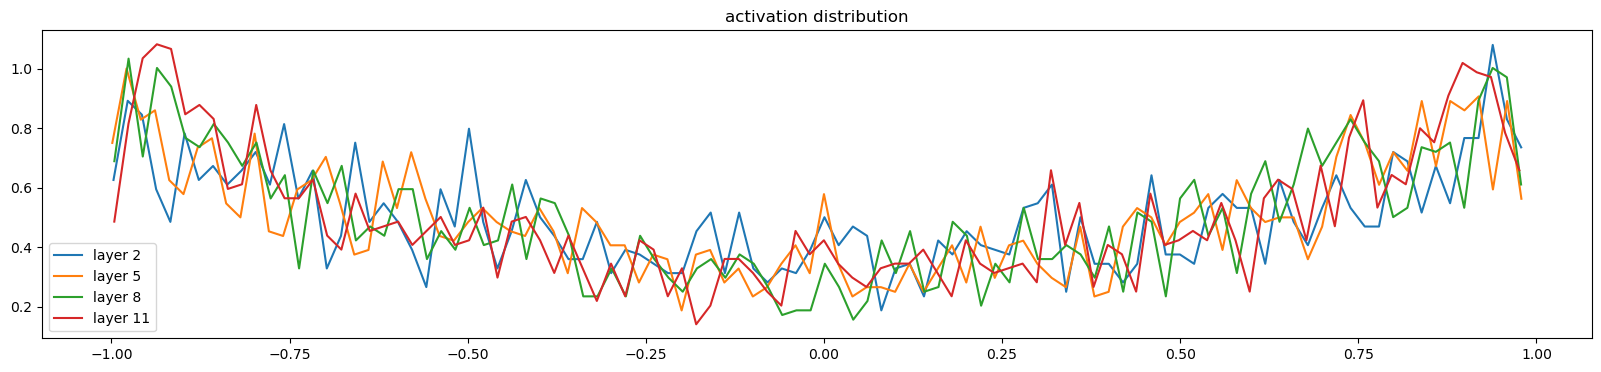

In [103]:
# visualise activations of tanh
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers):
    if isinstance(layer, Tanh):
        t = layer.out
        print('layer %d : mean %+.2f, std %.2f, saturated: %.2f%%' % (i, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i}')
plt.legend(legends);
plt.title('activation distribution')

layer 2 (      Tanh): mean +0.000000, std 4.469173e-03
layer 5 (      Tanh): mean +0.000000, std 4.602692e-03
layer 8 (      Tanh): mean +0.000000, std 4.729307e-03
layer 11 (      Tanh): mean -0.000000, std 4.105384e-03


Text(0.5, 1.0, 'Gradient Distribution')

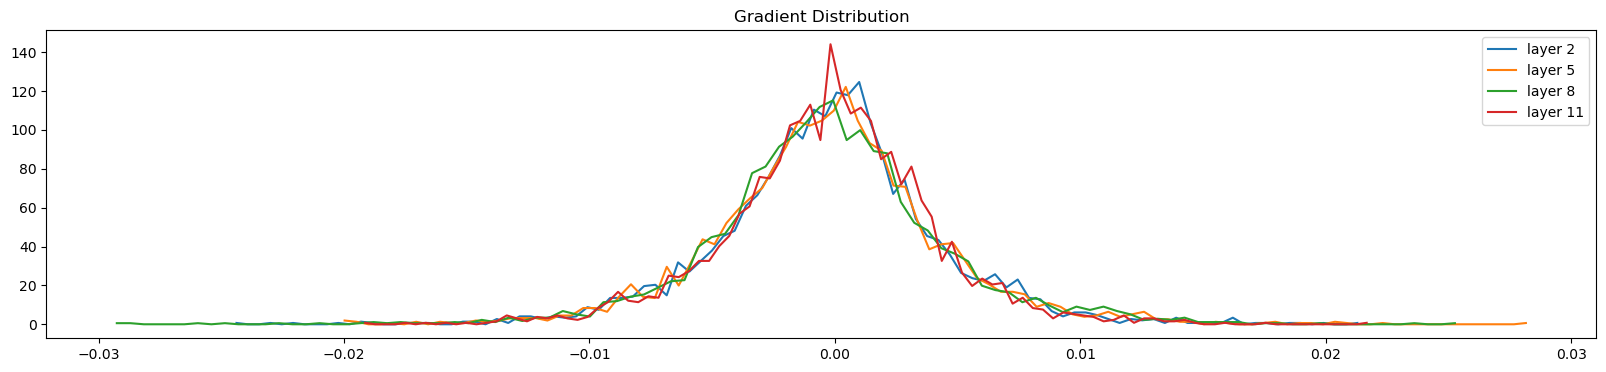

In [104]:
# visualise the gradients - they should have a somewhat normal distribution -> I think that there might be something wrong with this graph, it should not be constantly increasing help
plt.figure(figsize=(20,4))
legend = []
for i, layer in enumerate(layers):
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
        # hy is a representation of how frequenty they occur, while hx are the bins
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i}')

plt.legend(legends)
plt.title("Gradient Distribution")
        

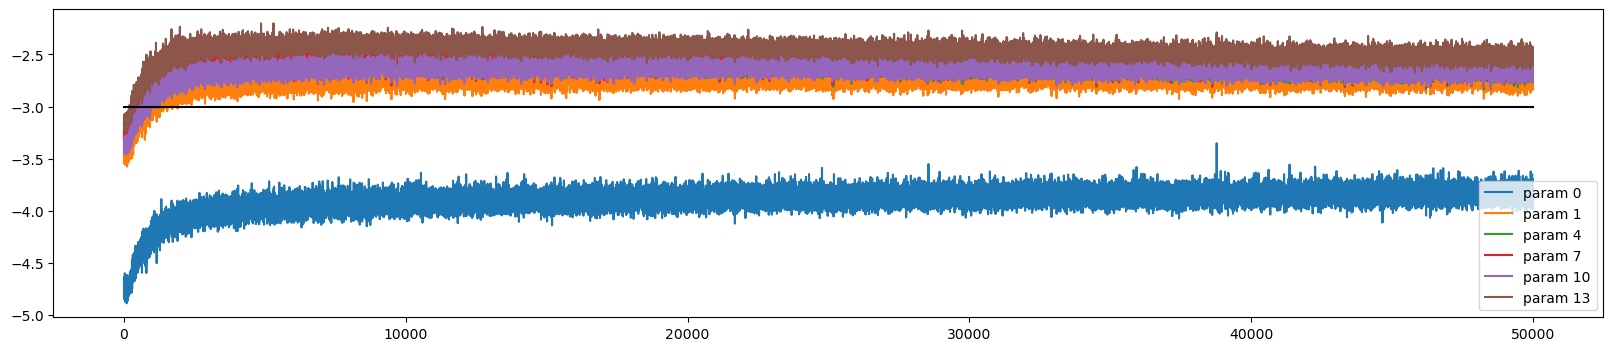

In [105]:
# collect an update to data ratio
plt.figure(figsize=(20, 4))
legends = []

for i,p in enumerate(parameters):
    # plot only the 2 dimensional nodes
    if p.ndim == 2:
        # this is basically tracking the layer across the list of parameters
        plt.plot([updates_to_data[j][i] for j in range(len(updates_to_data))])
        legends.append('param %d' % i)
plt.plot([0, len(updates_to_data)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends)